In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pickle
from itertools import product
from Utils_pfs import *

In [2]:
sales_train = pd.read_csv(r'sales_train_v2.csv')
items = pd.read_csv(r'items.csv')
item_categories = pd.read_csv(r'item_categories.csv')
shops = pd.read_csv(r'shops.csv')
sales_test = pd.read_csv(r'test.csv')

In [3]:
sales_test['ID'] = 34
sales_test.rename({'ID': 'date_block_num'}, axis = 1, inplace = True)
sales_test = sales_test.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

In [4]:
sales_train = sales_train.merge(items.loc[:,['item_category_id', 'item_id']], on = 'item_id', how = 'left')

Create Sales column

In [5]:
sales_train = sales_train[sales_train['item_cnt_day']<1000]
sales_train = sales_train[sales_train['item_price']<100000]

In [6]:
sales_train['sales'] = sales_train['item_cnt_day']*sales_train['item_price']

Creating a combination of all the item ids and shop ids in a month

In [7]:
sales_month = sales_train.loc[sales_train['date_block_num']==0, :]
unique_item = sales_month['item_id'].unique()
unique_shop = sales_month['shop_id'].unique()

In [8]:
sales_comb = []
for month in sales_train['date_block_num'].unique():
    sales_month = sales_train.loc[sales_train['date_block_num']==month, :]
    unique_item = sales_month['item_id'].unique()
    unique_shop = sales_month['shop_id'].unique()
    sales_comb.append(np.array(list(product(*[[month], unique_shop, unique_item]))))
sales_comb.append(np.array(list(product(*[[34], sales_test.shop_id.unique(), sales_test.item_id.unique()]))))
sales_comb = np.vstack(sales_comb)
sales_comb = pd.DataFrame(sales_comb, columns=['date_block_num', 'shop_id', 'item_id'])

In [9]:
sales_comb = sales_comb.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')

In [10]:
sales_comb.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
item_category_id    int64
dtype: object

Aggregating the data w.r.t shop id, item id and date_block_num

In [11]:
grouped_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop_item', 'sales': 'sales_shop_item', 'item_price': 'price_shop_item'}, axis = 1).reset_index()

Aggregating the data wrt shop_id and date_block_num

In [12]:
aggdata = sales_train.groupby(['date_block_num', 'shop_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_shop', 'sales': 'sales_shop', 'item_price': 'price_shop'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'shop_id'])

Aggregating the data wrt item_id and date_block_num

In [13]:
aggdata = sales_train.groupby(['date_block_num', 'item_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_item', 'sales': 'sales_item', 'item_price': 'price_item'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_id'])

Aggregating the data wrt item_category_id and date_block_num

In [14]:
grouped_data = grouped_data.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')

In [15]:
aggdata = sales_train.groupby(['date_block_num', 'item_category_id']).agg({
    'item_cnt_day':sum,
    'sales':sum,
    'item_price':'median'
}).rename({'item_cnt_day': 'cnt_itcat', 'sales': 'sales_itcat', 'item_price': 'price_itcat'}, axis = 1)
grouped_data = grouped_data.join(aggdata, on = ['date_block_num', 'item_category_id'])

In [16]:
grouped_data.head()

,date_block_num,shop_id,item_id,cnt_shop_item,sales_shop_item,price_shop_item,cnt_shop,sales_shop,price_shop,cnt_item,sales_item,price_item,item_category_id,cnt_itcat,sales_itcat,price_itcat
0,0,0,32,6.0,1326.0,221.0,5578.0,2966412.0,231.0,299.0,101515.86,349.0,40,33489.0,8667236.69,199.0
1,0,0,33,3.0,1041.0,347.0,5578.0,2966412.0,231.0,61.0,29831.00,499.0,37,6094.0,2845049.46,399.0
2,0,0,35,1.0,247.0,247.0,5578.0,2966412.0,231.0,78.0,30210.00,399.0,40,33489.0,8667236.69,199.0
3,0,0,43,1.0,221.0,221.0,5578.0,2966412.0,231.0,2.0,469.00,234.5,40,33489.0,8667236.69,199.0
4,0,0,51,2.0,257.0,128.5,5578.0,2966412.0,231.0,13.0,2996.00,249.0,57,1539.0,427204.87,299.0


Appending the test data as well

In [17]:
grouped_data = grouped_data.append(sales_test, sort = False).fillna(0)

In [18]:
grouped_data.tail()

,date_block_num,shop_id,item_id,cnt_shop_item,sales_shop_item,price_shop_item,cnt_shop,sales_shop,price_shop,cnt_item,sales_item,price_item,item_category_id,cnt_itcat,sales_itcat,price_itcat
214195,34,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.0,0.0,0.0
214196,34,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.0,0.0,0.0
214197,34,45,15757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.0,0.0,0.0
214198,34,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.0,0.0,0.0
214199,34,45,969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.0,0.0,0.0


Splitting date to day, month and year

In [19]:
date_mat = sales_train.date.str.split('.', expand = True).astype('int32')
date_mat.columns = ['day', 'month', 'year']
date_df = pd.concat([sales_train['date_block_num'], date_mat[['month', 'year']]], axis = 1)
date_df.drop_duplicates(inplace = True)
date_df = date_df.append([{'date_block_num': 34, 'month': 11, 'year': 2015}])

In [20]:
grouped_data = grouped_data.merge(date_df, on = 'date_block_num', how = 'left')

In [21]:
grouped_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'cnt_shop_item',
       'sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop',
       'price_shop', 'cnt_item', 'sales_item', 'price_item',
       'item_category_id', 'cnt_itcat', 'sales_itcat', 'price_itcat', 'month',
       'year'],
      dtype='object')

Clipping the cnt_shop_item between 0 and 20 to remove outliers

In [22]:
grouped_data['cnt_shop_item'].clip(0,20, inplace = True)

In [23]:
del aggdata

In [24]:
grouped_data = downcast_dtypes(grouped_data)

Merge sales_comb and grouped_data

In [25]:
sales_comb.head()

,date_block_num,shop_id,item_id,item_category_id
0,0,59,22154,37
1,0,59,2552,58
2,0,59,2554,58
3,0,59,2555,56
4,0,59,2564,59


In [26]:
merge_index = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
grouped_data = sales_comb.merge(grouped_data, on=merge_index, how = 'left').fillna(0)

In [27]:
grouped_data.shape

(11128004, 18)

In [28]:
del sales_comb

Creating Expanding Mean Encodings

In [29]:
enc_feat = ['shop_id', 'item_id', 'item_category_id', 'month', 'year']
target_feat = ['cnt_shop_item', 'cnt_shop', 'cnt_item', 'cnt_itcat']

In [30]:
enc_df = grouped_data[['date_block_num', 'shop_id', 'item_id']].copy()
for i in enc_feat:
    for j in target_feat:
        cum_sum = grouped_data.groupby(i).cumsum()[j] - grouped_data[j]
        cum_count = grouped_data.groupby(i).cumcount()
        enc_df[i+'_enc_'+j] = cum_sum/(cum_count+1)   

In [31]:
enc_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'shop_id_enc_cnt_shop_item',
       'shop_id_enc_cnt_shop', 'shop_id_enc_cnt_item', 'shop_id_enc_cnt_itcat',
       'item_id_enc_cnt_shop_item', 'item_id_enc_cnt_shop',
       'item_id_enc_cnt_item', 'item_id_enc_cnt_itcat',
       'item_category_id_enc_cnt_shop_item', 'item_category_id_enc_cnt_shop',
       'item_category_id_enc_cnt_item', 'item_category_id_enc_cnt_itcat',
       'month_enc_cnt_shop_item', 'month_enc_cnt_shop', 'month_enc_cnt_item',
       'month_enc_cnt_itcat', 'year_enc_cnt_shop_item', 'year_enc_cnt_shop',
       'year_enc_cnt_item', 'year_enc_cnt_itcat'],
      dtype='object')

In [32]:
enc_df.size

255944092

Creating Lagged Features

In [33]:
lag_feat = ['sales_shop_item', 'price_shop_item', 'sales_shop', 'price_shop',  
            'sales_item', 'price_item', 'sales_itcat', 'price_itcat']
lag_df = grouped_data[['date_block_num', 'shop_id', 'item_id']]
lag_int = [1,2]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id']+lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]

In [34]:
lag_feat = ['cnt_shop_item','cnt_shop', 'cnt_item', 'cnt_itcat']
lag_int = [1,2,3,5,12]
for i in lag_int:
    key_df = grouped_data[['date_block_num', 'shop_id', 'item_id'] + lag_feat].copy()
    key_df['date_block_num'] = key_df['date_block_num']+i
    lag_df = lag_df.merge(key_df, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left').fillna(0)
    lag_df.columns = [j + '_lag_'+ str(i) if j in lag_feat else j for j in lag_df.columns]
del key_df

In [35]:
lag_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_shop_item_lag_1',
       'price_shop_item_lag_1', 'sales_shop_lag_1', 'price_shop_lag_1',
       'sales_item_lag_1', 'price_item_lag_1', 'sales_itcat_lag_1',
       'price_itcat_lag_1', 'sales_shop_item_lag_2', 'price_shop_item_lag_2',
       'sales_shop_lag_2', 'price_shop_lag_2', 'sales_item_lag_2',
       'price_item_lag_2', 'sales_itcat_lag_2', 'price_itcat_lag_2',
       'cnt_shop_item_lag_1', 'cnt_shop_lag_1', 'cnt_item_lag_1',
       'cnt_itcat_lag_1', 'cnt_shop_item_lag_2', 'cnt_shop_lag_2',
       'cnt_item_lag_2', 'cnt_itcat_lag_2', 'cnt_shop_item_lag_3',
       'cnt_shop_lag_3', 'cnt_item_lag_3', 'cnt_itcat_lag_3',
       'cnt_shop_item_lag_5', 'cnt_shop_lag_5', 'cnt_item_lag_5',
       'cnt_itcat_lag_5', 'cnt_shop_item_lag_12', 'cnt_shop_lag_12',
       'cnt_item_lag_12', 'cnt_itcat_lag_12'],
      dtype='object')

In [39]:
grouped_data = grouped_data.loc[grouped_data['date_block_num']>=12,:]
enc_df = enc_df.loc[enc_df['date_block_num']>=12,:]
lag_df = lag_df.loc[lag_df['date_block_num']>=12,:]

Exploiting text features in item category and item names

In [40]:
n_comp = 2

In [41]:
text_feat = ['item_id', 'item_category_id']
if 'item_id' in text_feat:
    text_df = items[['item_name', 'item_id']].copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_name_' + str(i) for i in np.arange(1,n_comp+1)])
    item_name_df = pd.concat((text_df['item_id'], svd_df), axis = 1)
if 'item_category_id' in text_feat:
    text_df = item_categories.copy()
    tv = TfidfVectorizer()
    tv_df = tv.fit_transform(text_df['item_category_name'])
    svd = TruncatedSVD(n_components=n_comp, random_state = 24)
    svd_df = svd.fit_transform(tv_df)
    svd_df = pd.DataFrame(data = svd_df, columns = ['item_category_name_' + str(i) for i in np.arange(1,n_comp+1)])
    item_category_name_df = pd.concat((text_df['item_category_id'], svd_df), axis = 1)
del tv_df, svd_df, text_df, svd, tv

In [42]:
text_df = grouped_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']].copy()
text_df = text_df.merge(item_name_df, on = 'item_id', how = 'left')
text_df = text_df.merge(item_category_name_df, on = 'item_category_id', how = 'left')

In [43]:
text_df.drop('item_category_id', axis = 1, inplace = True)
text_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_name_1', 'item_name_2',
       'item_category_name_1', 'item_category_name_2'],
      dtype='object')

In [44]:
for df in [grouped_data, enc_df, lag_df, text_df]:
    print(df.shape)

(6639294, 18)
(6639294, 23)
(6639294, 39)
(6639294, 7)


Merging all the datasets to create the full set

In [45]:
full_data = grouped_data.copy()
key_feat = ['date_block_num', 'shop_id', 'item_id']
df = [enc_df, lag_df, text_df]
for i in df:
    full_data = full_data.merge(i, on = key_feat, how = 'left')

In [46]:
full_data.shape

(6639294, 78)

In [47]:
full_data.isnull().sum().sum()

0

In [48]:
del grouped_data, enc_df, lag_df, text_df

Dropping non required columns

In [49]:
to_drop = ['sales_shop_item', 'price_shop_item', 'cnt_shop', 'sales_shop', 'price_shop', 'cnt_item', 'sales_item', 'price_item',
           'cnt_itcat', 'sales_itcat', 'price_itcat']
full_data.drop(to_drop, axis=1, inplace = True)

In [50]:
full_data.shape

(6639294, 67)

In [51]:
full_data = downcast_dtypes(full_data)

In [52]:
with open('full_data_3.pkl', 'wb') as handle:  
    pickle.dump(full_data,handle,protocol=-1)

Implementing a catboost model to find validation sets

In [5]:
with open('full_data_3.pkl', 'rb') as file:
    full_data = pickle.load(file)

In [6]:
dict_cat = create_cv_sets2([22,33], full_data, sales_test)

In [22]:
with open('dict_cat.pkl', 'wb') as handle:  
    pickle.dump(dict_cat,handle,protocol=-1)

In [7]:
del full_data

In [10]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, max_depth=10)
rf.fit(dict_cat['train'], dict_cat['train_y'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
with open('rf_new.pkl','wb') as handle:
    pickle.dump(rf,handle,protocol=-1)

In [14]:
val_score = rf.score(dict_cat['val'], dict_cat['val_y'])

In [67]:
pred = rf.predict(dict_cat['test'])

In [68]:
create_submission_file(pred, 'rf_new', sales_test)

Gauge feature importance using mean reduced error

In [15]:
rf_err = []
val_y = dict_cat['val_y'].copy()
for i in range(dict_cat['val'].columns.shape[0]):
    val_set = dict_cat['val'].copy()
    np.random.shuffle(val_set.iloc[:,i].values)
    rf_err.append((rf.score(val_set, val_y)-val_score)/val_score)

In [18]:
rc('figure', figsize=(15, 5))

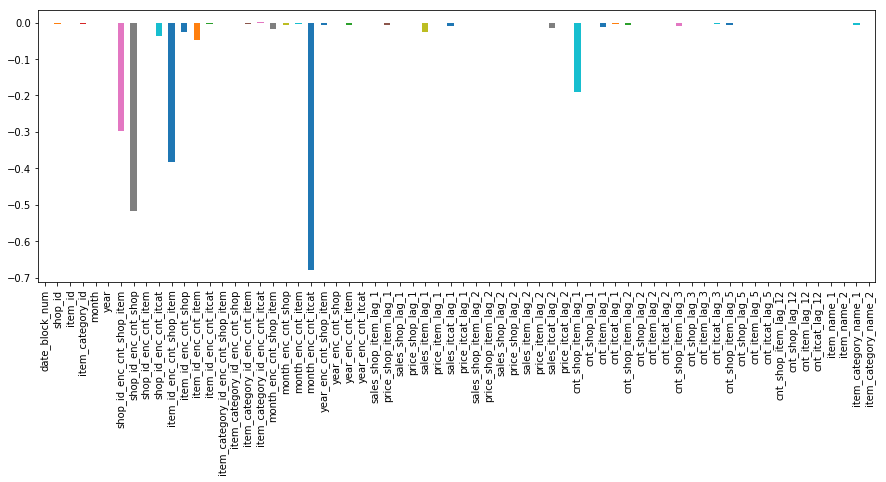

In [19]:
pd.Series(data = rf_err, index=dict_cat['train'].columns).plot(kind='bar')

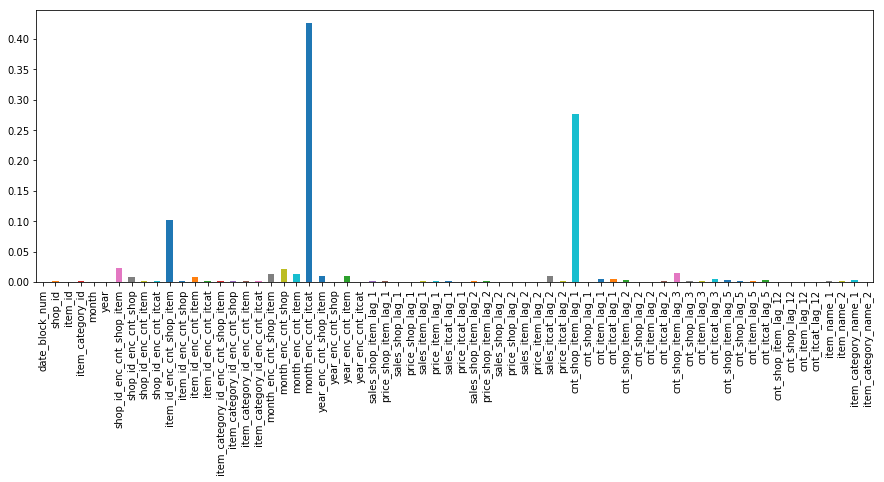

In [21]:
pd.Series(data = rf.feature_importances_, index=dict_cat['train'].columns).plot(kind='bar')